### Dependencies

In [1]:
!pip install -r requirements.txt
!apt-get update -y
!apt-get upgrade -y
!apt-get install git
# apt-get update && apt-get install ffmpeg libsm6 libxext6  -y       RUN IN TERMINAL

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 14.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 48.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 25.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 31.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.2/189.2 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 31.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 32.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Data

We need .jpeg MRI slices and .pt file with MRI masks to train the model. We place them in the mri_data directory. \
MRI: mri_data/MRI-slices/{name-of-dir-for-current-task} \
MRI masks: mri_data/MRI-masks/{name-of-file-for-current-task} 

In [2]:
!mkdir -p mri_data
!mkdir -p mri_data/MRI-slices
!mkdir -p mri_data/MRI-masks

After creating the dirs we fill them with actual data

In [8]:
source_mri_slices_dir = "../mri-slices-ext"                 #edit according to the real place of your source data
source_mri_masks_file = "../best_slices_labels_ext.pt"      #edit according to the real place of your source data

dest_mri_slices_dir = "mri_data/MRI-slices/mri-slices-ext"             #edit dir name according to current task
dest_mri_masks_file = "mri_data/MRI-masks/best_slices_labels_ext.pt"   #edit file name according to current task

!cp -r {source_mri_slices_dir + "/."} {dest_mri_slices_dir}
!cp {source_mri_masks_file} {dest_mri_masks_file}

### Config

Now we have to adjust configuration file. Here we read json file with comments, edit, and write the new configuration file without any comments.

In [4]:
import jstyleson                                        #used for reading non-standard json file with c-style comments
import json

old_config_name = "inpainting_celebahq.json"
config_name = "mri-inpainting.json"                     #edit according to the name of your experiment

with open("config/" + old_config_name, "r") as file:
    conf = jstyleson.loads(file.read())

Set all properties in config file.

In [5]:
conf['datasets']['train']['which_dataset']['args']['data_root'] = dest_mri_slices_dir
conf['datasets']['train']['which_dataset']['args']['mask_config']['mask_mode'] = 'file'
conf['datasets']['train']['which_dataset']['args']['mask_config']['mask_file'] = dest_mri_masks_file

conf['train']['val_epoch'] = 2
conf['train']['save_checkpoint_epoch'] = 10

conf['gpu_ids'] = [2]
conf['path']['resume_state'] = "experiments/train_inpainting-mri-real-masks_240330_183821/checkpoint/10"
conf['datasets']['test']['which_dataset']['args']['data_root'] = dest_mri_slices_dir
conf['datasets']['test']['which_dataset']['args']['mask_config']['mask_mode'] = 'bbox'
conf['name'] = 'inpainting-mri-real-masks'

In [6]:
with open("config/" + config_name, 'w') as fp:
    json.dump(conf, fp, indent=2)

Also change .gitignore file in order to hide heavy folders from git

In [7]:
dirs_to_exclude = ["mri_data/\n", "experiments/\n"]

gitignore_file = ".gitignore"

with open(gitignore_file, 'r+') as file:
    lines = file.readlines()
    for dir in dirs_to_exclude:
        if dir not in lines:
            file.write(dir)

### Running the model

Now we can train the model. All results (checkpoints, generated images, ...) will be saved in the experiments dir

In [9]:
!python run.py -p train -c config/{config_name}

Namespace(batch=None, config='config/mri-inpainting.json', debug=False, gpu_ids=None, phase='train', port='21012')
export CUDA_VISIBLE_DEVICES=2
run.py:29: UserWarning: You have chosen to use cudnn for accleration. torch.backends.cudnn.enabled=True
  warnings.warn('You have chosen to use cudnn for accleration. torch.backends.cudnn.enabled=True')
  9%|███▊                                      | 30/327 [00:19<03:14,  1.53it/s]
Close the Tensorboard SummaryWriter.
Traceback (most recent call last):
  File "run.py", line 96, in <module>
    main_worker(0, 1, opt)
  File "run.py", line 61, in main_worker
    model.train()
  File "/workspace/palette-mri-inpainting-3d/core/base_model.py", line 45, in train
    train_log = self.train_step()
  File "/workspace/palette-mri-inpainting-3d/models/model.py", line 125, in train_step
    self.EMA.update_model_average(self.netG_EMA, self.netG)
  File "/workspace/palette-mri-inpainting-3d/models/model.py", line 13, in update_model_average
    ma_params.

Now we should edit configuration file before testing the model in order to use the last checkpoint. Checkpoint should have the following format: "experiments/train_inpainting_celebahq_240304_171920/checkpoint/540"

In [8]:
import os

runs = sorted([log for log in os.listdir("experiments") if conf["name"] in log and 'train' in log])
checkpoints = sorted(os.listdir(f"experiments/{runs[-1]}/checkpoint"), key=lambda name: int(name.replace('_', '.').split('.')[0]))
checkpoint = f"experiments/{runs[-1]}/checkpoint/{checkpoints[-1].replace('_', '.').split('.')[0]}"

with open("config/" + config_name, "r") as file:
    conf = jstyleson.loads(file.read())
    conf['path']['resume_state'] = checkpoint

with open("config/" + config_name, 'w') as fp:
    json.dump(conf, fp, indent=2)

print(checkpoint)

experiments/train_inpainting-mri-real-masks_240410_150846/checkpoint/600


Then we can test the model. Results will be saved in the experiments dir as well.

In [21]:
!python run.py -p test -c config/{config_name}

export CUDA_VISIBLE_DEVICES=2
run.py:29: UserWarning: You have chosen to use cudnn for accleration. torch.backends.cudnn.enabled=True
  warnings.warn('You have chosen to use cudnn for accleration. torch.backends.cudnn.enabled=True')
  0%|                                                   | 0/985 [00:04<?, ?it/s]
Close the Tensorboard SummaryWriter.
Traceback (most recent call last):
  File "run.py", line 95, in <module>
    main_worker(0, 1, opt)
  File "run.py", line 63, in main_worker
    model.test()
  File "/workspace/Palette-Image-to-Image-Diffusion-Models/models/model.py", line 178, in test
    self.output, self.visuals = self.netG.restoration(self.cond_image, y_t=self.cond_image, 
  File "/root/miniconda3/lib/python3.8/site-packages/torch/autograd/grad_mode.py", line 27, in decorate_context
    return func(*args, **kwargs)
  File "/workspace/Palette-Image-to-Image-Diffusion-Models/models/network.py", line 98, in restoration
    y_t = self.p_sample(y_t, t, y_cond=y_cond)
  File "

### Processing the outputs

In [ ]:
!mkdir -p generations-postprocessing
!mkdir -p generations-postprocessing

In [110]:
len(os.listdir(dest_mri_slices_dir)) 

985

gt_image is the full input image, not the generated one!

In [1]:
%load_ext tensorboard

In [3]:
#successful attempt to run tensorboard in docker on remote machine with vpn 
%tensorboard  --logdir=experiments/train_inpainting-mri-real-masks_240421_193924/tb_logger --port=6006 --host 0.0.0.0

### Visualization

In [12]:
from PIL import Image
import os
import re

In [21]:
runs = sorted([log for log in os.listdir("experiments") if conf["name"] in log and 'test' in log])
test_dir = f"experiments/{runs[-1]}/results/test/0"
test_dir

'experiments/test_inpainting-mri-real-masks_240411_130004/results/test/0'

In [13]:
def sort_files(files):
    return sorted(files, key = lambda path: int(path[re.search(r"\d+", path).start() : re.search(r"\d+", path).end()]))

In [16]:
files = os.listdir(test_dir)

origs = sort_files([file for file in files if 'GT' in file])
masks = sort_files([file for file in files if 'Mask' in file])
gens =  sort_files([file for file in files if 'Out' in file])

In [17]:
total_h = 256 * len(origs)
total_w = 256 * 3

In [18]:
new_image = Image.new('RGB', (total_w, total_h), 'white')

In [19]:
triple_images = []
h_offset = 0
for orig, mask, gen in zip(origs, masks, gens):
    new_image = Image.new('RGB', (256 * 3, 256), 'white')
    new_image.paste(Image.open(os.path.join(test_dir, orig)), (0, 0))
    new_image.paste(Image.open(os.path.join(test_dir, mask)), (256, 0))
    new_image.paste(Image.open(os.path.join(test_dir, gen)),  (256*2, 0))
    triple_images.append(new_image)

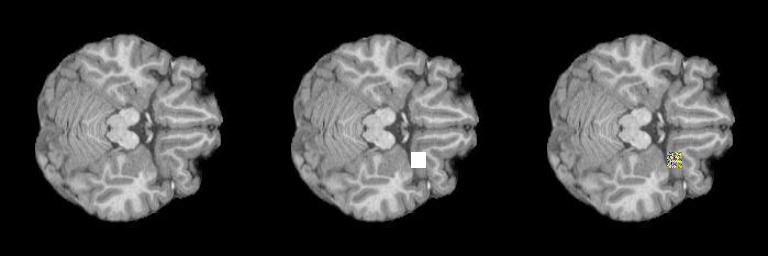

In [20]:
triple_images[0]

### Model structure

Palette model (model.py) uses self.netG in its core (loss = self.netG(self.gt_image, self.cond_image, mask=self.mask)). self.netG is an object of Network class (network.py) which in its turn employs Unet architecture (self.denoise_fn) defined in our case in the file guided_diffusion_modules/unet.py 

At the moment, it seems to me that the problem of adapting the architecture to 3D boils down to changing the unet.py in appropriate way and introducing minor changes to other files. 

### Inference from Notebook

1) Run the model on inference on 1 slice
2) Run the model on all slices to reconstruct 3D MRI

In [2]:
import argparse
import os
import subprocess
import warnings
import torch
import torch.multiprocessing as mp

from core.logger import VisualWriter, InfoLogger
import core.praser as Praser
import core.util as Util
from data import define_dataloader
from models import create_model, define_network, define_loss, define_metric

from run import main_worker, get_model

import PIL
from torchvision import transforms
import numpy as np
import re
import matplotlib.pyplot as plt

In [5]:
args = argparse.Namespace()
args.config = f"config/{config_name}"
args.phase = 'test'
args.batch = None
args.gpu_ids = None
args.debug = False
args.port = '21012'

opt = Praser.parse(args)
opt['world_size'] = 1 
opt['model']['which_networks'][0]['args']['unet']['image_size'] = (256, 256)

In [6]:
model = get_model(0, 1, opt)
net = model.netG        

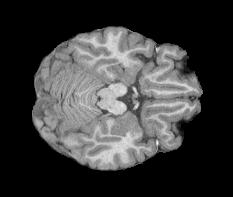

In [9]:
images = [file for file in os.listdir(dest_mri_slices_dir) if '.jpeg' in file]
images = sorted(images, key = lambda path: int(path[re.search(r"\d+", path).start() : re.search(r"\d+", path).end()]))
img = PIL.Image.open(os.path.join(dest_mri_slices_dir, images[0]))
img

In [10]:
image_size = opt['model']['which_networks'][0]['args']['unet']['image_size']

tfs = transforms.Compose([
                transforms.Resize((image_size[0], image_size[1])),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5, 0.5])
      ])

img = tfs(img)

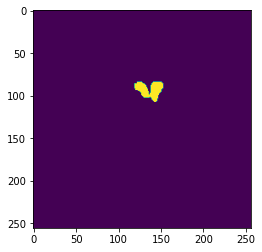

In [11]:
masks = torch.load(opt['datasets']['train']['which_dataset']['args']['mask_config']['mask_file']).astype(np.uint8)
mask_tfs = transforms.Resize((image_size[0], image_size[1]))

mask = masks[0]
mask = mask[np.newaxis, :, :]  
mask = mask_tfs(torch.from_numpy(mask)).numpy() 
mask = np.transpose(mask, (1, 2, 0))
plt.imshow(mask)
plt.show()

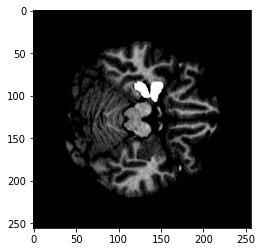

In [12]:
mask = torch.from_numpy(mask).permute(2, 0, 1)
cond_image = img * (1. - mask) + mask * torch.randn_like(img)
mask_img = img * (1. - mask) + mask

plt.imshow(mask_img.permute(1, 2, 0))

In [13]:
cond_image = cond_image.unsqueeze(0) 
img = img.unsqueeze(0)
mask = mask.unsqueeze(0)

In [15]:
net.eval()

output, visuals = net.restoration(cond_image.cuda(), y_t=cond_image.cuda(), 
                                  y_0=img.cuda(), mask=mask.cuda(), sample_num=1)

sampling loop time step: 100%|██████████| 1000/1000 [00:31<00:00, 31.91it/s]


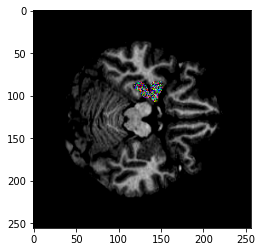

In [16]:
plt.imshow(output.cpu()[0].permute(1, 2, 0))

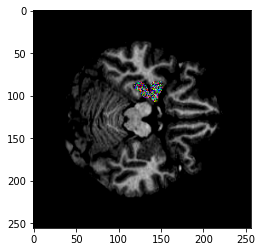

In [17]:
plt.imshow(visuals.cpu()[1].permute(1, 2, 0))